# Gesture Recognition 

__By : SOUMAYADEEP MANNA__

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognize five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

__1. Thumbs up:  Increase the volume__<br>
__2. Thumbs down: Decrease the volume__<br>
__3. Left swipe: 'Jump' backwards 10 seconds__<br>
__4. Right swipe: 'Jump' forward 10 seconds__<br>
__5. Stop: Pause the movie__<br>

### Understanding the Dataset

The training data consists of a few hundred videos categorized into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into sub folders where each sub folder represents a video of a particular gesture. Each sub folder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video sub folder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardize the videos. 

### Goals of this Project

In this project, you will build a model to recognize 5 hand gestures.The following needs to be accomplished in the project:

__1. Generator:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.__

__2. Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.__

__3. Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.__ 

## Installing and Importing necessary libraries and packages:

In [ ]:
#!pip install imageio

In [1]:
import numpy as np
import os
from imageio import imread
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import abc

In [2]:
import scipy.stats
import cv2

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

__This block of code used to set the memory limit of the local GPU.__

In [4]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=3200)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     print(e)

1 Physical GPUs, 1 Logical GPUs


__Importing necessary Tensorflow and Keras Models and Modules__

In [5]:
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import LSTM

### Path of the Data Directory:

In [6]:
data_dir = "D:\\Work\\UpGrad\\Assignment RNN\\Local\\Project_data"

### Method to Plot Model Results:

In [7]:
def result_plotting(history,epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model Builder and Data Generator:

In the generator, we are going to pre-process the images as you have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with img_idx, y,z and normalization such that you get high accuracy.

We defined a Class named as __ModelBuilder__, this class contains all the model building, data generation and pre processing methods as follows:

-  set_data_path: __Loads the training and validation data from the data directory.__
-  set_image_properties: __defines the images dimensions, color channels and frames.__
-  set_hyperparams: __defines the initial hyper parameters required for model building such as batch size, epoch etc.__
-  get_batch_data: __method used to pre-process, normalize and apply augmentation on the data.__ 
-  data_generator: __method used to generate the data for training and validation in batches with random combinations.__
-  train_model: __method used to train the model, save the best model and return the model result.__

In [8]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    # Loads the training and validation data from the data directory.
    def set_data_path(self,data_dir):
        self.train_data_list = np.random.permutation(open(data_dir + '\\' + 'train.csv').readlines())
        self.val_data_list = np.random.permutation(open(data_dir + '\\' + 'val.csv').readlines())
        self.train_data_path = data_dir + '\\' + 'train'
        self.val_data_path =  data_dir + '\\' + 'val'
        self.num_train_sequences = len(self.train_data_list)
        self.num_val_sequences = len(self.val_data_list)
        
    # initialising the image dimension, frame size and color channels    
    def set_image_properties(self,image_height=160,image_width=160):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        
    # initialising the basic hyper parameters for model batchsize, epochs & frames to process
    def set_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # applying pre processing, augmentation of the data    
    def get_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
        
         # augmentation will only be apllied when it will be set as true in model param
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'\\'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                
                #image reading and resizing
                image = imread(source_path+'\\'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width),interpolation=cv2.INTER_AREA)
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                # augmentation will only be apllied when it will be set as true in model param
                if (augment):
                    shiftedImages = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0])) # image shifting
                    
                    grayscale = cv2.cvtColor(shiftedImages,cv2.COLOR_BGR2GRAY) # converting to grayscale

                    x0, y0 = np.argwhere(grayscale > 0).min(axis=0)
                    x1, y1 = np.argwhere(grayscale > 0).max(axis=0) 
                    
                    # cropping the images to have focus on the main gesture part in the image
                    cropped=shiftedImages[x0:x1,y0:y1,:]
                    
                    #resizing the cropped image
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width),interpolation=cv2.INTER_AREA)
                    
                    # normalizing the augmented images
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        # augmentation will only be apllied when it will be set as true in model param
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        # returning procesed data 
        return(batch_data,batch_labels)
        
    # Function generates the data for processing based on batch size and random combination mentioned        
    def data_generator(self,source_path, folder_list, augment=False):
        
        #index of the image
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            
            #returning the data in combined batches
            for batch in range(num_batches): 
                batch_data, batch_labels= self.get_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.get_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    # function defined to train, load and save the model details 
    def train_model(self, model, augment_data=False):
        
        train_generator = self.data_generator(self.train_data_path, self.train_data_list,augment=augment_data) # train data 
        val_generator = self.data_generator(self.val_data_path, self.val_data_list) # validation data

        model_name = 'gestureRecognitionModel' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.4f}-{categorical_accuracy:.4f}-{val_loss:.4f}-{val_categorical_accuracy:.4f}.h5'
        
        # details to be saved on model training
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        # if model loss doesn't improve with epoch training will stop early
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        # saving the history of the model
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### Defining a initial Model to understand the behaviour : 

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  ## 3D CNN layer with max pool and normalization

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  ## 3D CNN layer with max pool and normalization

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2))) ## 3D CNN layer with max pool and normalization


        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())     
        model.add(Dropout(0.5))                      ## Dense layer with dropout

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))                    ## Dense layer with dropout
 

        model.add(Dense(self.num_classes,activation='softmax'))
        
        # defining the optimizer function
        adam = tf.keras.optimizers.Adam()
        model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
# initializing the model with parametes
# image size 160 x 160
# frames to process 30

conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=160,image_width=160)
conv_3d1.set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)

# defining the model
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

#### Sample method to test data generation and visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


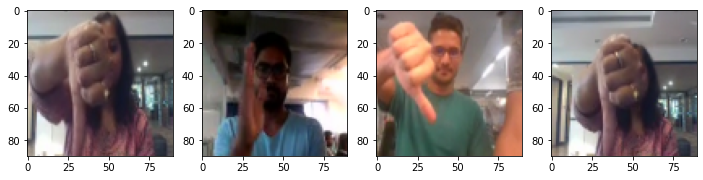

In [14]:
test_generator=ModelConv3D1()
test_generator.set_data_path(data_dir)
test_generator.set_image_properties(image_height=90,image_width=90)
test_generator.set_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.data_generator(test_generator.val_data_path,test_generator.val_data_list,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,12))
axes[0].imshow(batch_data[5,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])
axes[2].imshow(batch_data[4,20,:,:,:])   
axes[3].imshow(batch_data[2,20,:,:,:])
plt.show()

In [15]:
# training and fitting the model
conv_3d1.train_model(conv_3d1_model)

 1/67 [..............................] - ETA: 14:16 - loss: 2.6723 - categorical_accuracy: 0.2000

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad' defined at (most recent call last):
    File "D:\Installed_Softy\anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Installed_Softy\anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "D:\Installed_Softy\anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "D:\Installed_Softy\anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\Installed_Softy\anaconda\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "D:\Installed_Softy\anaconda\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "D:\Installed_Softy\anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\Installed_Softy\anaconda\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Installed_Softy\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "D:\Installed_Softy\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "D:\Installed_Softy\anaconda\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Installed_Softy\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Installed_Softy\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Installed_Softy\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_2660\1888540469.py", line 2, in <cell line: 2>
      conv_3d1.train_model(conv_3d1_model)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_2660\833239309.py", line 139, in train_model
      history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "D:\Installed_Softy\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad'
OOM when allocating tensor with shape[10,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2023]

__We have exceed maximum GPU memory processing capacity, which means we need to reduce the total number of parameters in the model and also hyper parameters to train the model.__

### For Model training and execution following parameters are dependent on model performance :


-  Image resolution ( image width and image height)
-  Batch Size of Data
-  No of image frames to process
-  number of epochs

__So we will perform some experiments to see how training time is affected by image resolution, number of images in sequence and batch size.__

__Experiment 1:__

- Image Resolution 160x160, frames=16, batch_size =30

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=160,image_width=160)
conv_3d1.set_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 6585413
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5018 - categorical_accuracy: 0.4359
Epoch 1: val_loss improved from inf to 26.49478, saving model to gestureRecognitionModel_2022-09-1713_24_54.346996\model-00001-1.5018-0.4359-26.4948-0.2100.h5
67/67 [==============================] - 84s 1s/step - loss: 1.5018 - categorical_accuracy: 0.4359 - val_loss: 26.4948 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.0478 - categorical_accuracy: 0.6078
Epoch 2: val_loss did not improve from 26.49478
67/67 [==============================] - 59s 894ms/step - loss: 1.0478 - categorical_accuracy: 0.6078 - val_loss: 78.9638 - val_categorical_accuracy: 0.2300 - lr: 0.0010


__Experiment 2:__

- Image Resolution 120x120, frames=25, batch_size =16

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=120,image_width=120)
conv_3d1.set_hyperparams(frames_to_sample=25,batch_size=16,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 5561413
Epoch 1/2
42/42 [==============================] - ETA: 0s - loss: 1.3969 - categorical_accuracy: 0.4646
Epoch 1: val_loss improved from inf to 4.51116, saving model to gestureRecognitionModel_2022-09-1713_28_00.197545\model-00001-1.3969-0.4646-4.5112-0.2100.h5
42/42 [==============================] - 96s 2s/step - loss: 1.3969 - categorical_accuracy: 0.4646 - val_loss: 4.5112 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
42/42 [==============================] - ETA: 0s - loss: 0.8744 - categorical_accuracy: 0.6637
Epoch 2: val_loss did not improve from 4.51116
42/42 [==============================] - 83s 2s/step - loss: 0.8744 - categorical_accuracy: 0.6637 - val_loss: 16.8908 - val_categorical_accuracy: 0.2500 - lr: 0.0010


__Experiment 3:__

- Image Resolution 90x90, frames=25, batch_size =16

In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=90,image_width=90)
conv_3d1.set_hyperparams(frames_to_sample=25,batch_size=16,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 3005509
Epoch 1/2
42/42 [==============================] - ETA: 0s - loss: 1.4382 - categorical_accuracy: 0.4781
Epoch 1: val_loss improved from inf to 2.01228, saving model to gestureRecognitionModel_2022-09-1713_32_22.040338\model-00001-1.4382-0.4781-2.0123-0.2100.h5
42/42 [==============================] - 84s 2s/step - loss: 1.4382 - categorical_accuracy: 0.4781 - val_loss: 2.0123 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
42/42 [==============================] - ETA: 0s - loss: 0.9770 - categorical_accuracy: 0.6033
Epoch 2: val_loss did not improve from 2.01228
42/42 [==============================] - 81s 2s/step - loss: 0.9770 - categorical_accuracy: 0.6033 - val_loss: 5.4330 - val_categorical_accuracy: 0.1900 - lr: 0.0010


__Experiment 4:__

- Image Resolution 100X100, frames=30, batch_size =10

In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=100,image_width=100)
conv_3d1.set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 3570757
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.4665 - categorical_accuracy: 0.4646
Epoch 1: val_loss improved from inf to 5.82344, saving model to gestureRecognitionModel_2022-09-1713_58_41.213649\model-00001-1.4665-0.4646-5.8234-0.1600.h5
67/67 [==============================] - 112s 2s/step - loss: 1.4665 - categorical_accuracy: 0.4646 - val_loss: 5.8234 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 0.8965 - categorical_accuracy: 0.6561
Epoch 2: val_loss did not improve from 5.82344
67/67 [==============================] - 104s 2s/step - loss: 0.8965 - categorical_accuracy: 0.6561 - val_loss: 13.2423 - val_categorical_accuracy: 0.1800 - lr: 0.0010


__Experiment 5:__

- Image Resolution 100x100, frames=18, batch_size =2

In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=100,image_width=100)
conv_3d1.set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 2391109
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.4751 - categorical_accuracy: 0.4646
Epoch 1: val_loss improved from inf to 17.58157, saving model to gestureRecognitionModel_2022-09-1714_02_31.838063\model-00001-1.4751-0.4646-17.5816-0.1600.h5
67/67 [==============================] - 42s 582ms/step - loss: 1.4751 - categorical_accuracy: 0.4646 - val_loss: 17.5816 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.0360 - categorical_accuracy: 0.6275
Epoch 2: val_loss did not improve from 17.58157
67/67 [==============================] - 29s 432ms/step - loss: 1.0360 - categorical_accuracy: 0.6275 - val_loss: 38.8383 - val_categorical_accuracy: 0.1600 - lr: 0.0010


__Experiment 6:__

- Image Resolution 120x120, frames=20, batch_size =16

In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=100,image_width=100)
conv_3d1.set_hyperparams(frames_to_sample=20,batch_size=16,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 2391109
Epoch 1/2
42/42 [==============================] - ETA: 0s - loss: 1.2652 - categorical_accuracy: 0.5279
Epoch 1: val_loss improved from inf to 4.76308, saving model to gestureRecognitionModel_2022-09-1714_05_00.090630\model-00001-1.2652-0.5279-4.7631-0.2100.h5
42/42 [==============================] - 40s 915ms/step - loss: 1.2652 - categorical_accuracy: 0.5279 - val_loss: 4.7631 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
42/42 [==============================] - ETA: 0s - loss: 0.7618 - categorical_accuracy: 0.6983
Epoch 2: val_loss did not improve from 4.76308
42/42 [==============================] - 34s 817ms/step - loss: 0.7618 - categorical_accuracy: 0.6983 - val_loss: 8.9150 - val_categorical_accuracy: 0.2200 - lr: 0.0010


__Experiment 7:__

- Image Resolution 120x120, frames=25, batch_size =10

In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=120,image_width=120)
conv_3d1.set_hyperparams(frames_to_sample=25,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 5561413
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6037 - categorical_accuracy: 0.4042
Epoch 1: val_loss improved from inf to 5.96895, saving model to gestureRecognitionModel_2022-09-1714_06_38.760502\model-00001-1.6037-0.4042-5.9690-0.2200.h5
67/67 [==============================] - 43s 615ms/step - loss: 1.6037 - categorical_accuracy: 0.4042 - val_loss: 5.9690 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2168 - categorical_accuracy: 0.5204
Epoch 2: val_loss did not improve from 5.96895
67/67 [==============================] - 40s 610ms/step - loss: 1.2168 - categorical_accuracy: 0.5204 - val_loss: 10.5470 - val_categorical_accuracy: 0.2500 - lr: 0.0010


### Observations from experiments :

From the above set of experiments we have observed following effects and relation with the model hyper parameters as follows :

1. __With the high resolution and number of frames training time increases.__
2. __Higher resolution and lower batch size have high loss.__
3. __We will be considering Batch Sizes around - 8 / 10 / 16__
4. __We will be using resolution of the images according to model performance - 160X160 / 120X120 / 100X100__
5. __Number of frames we can use between - 16-25__

__Lets implement the following and get started with model building.__

## Model Building

### Model 1 without  data augmentation

__Base Model - Built on 3D CNN Convolution Model__ 

In [23]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3)):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution - 160x160 / Frames - 20 / Batch Size - 10__

In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.set_data_path(data_dir)
conv_3d1.set_image_properties(image_height=160,image_width=160)
conv_3d1.set_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=20)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_40 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_25 (Activation)  (None, 10, 80, 80, 32)   

In [25]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7590 - categorical_accuracy: 0.3439
Epoch 1: val_loss improved from inf to 2.21306, saving model to gestureRecognitionModel_2022-09-1714_17_50.341044\model-00001-1.7590-0.3439-2.2131-0.2100.h5
67/67 [==============================] - 46s 655ms/step - loss: 1.7590 - categorical_accuracy: 0.3439 - val_loss: 2.2131 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5190 - categorical_accuracy: 0.4012
Epoch 2: val_loss did not improve from 2.21306
67/67 [==============================] - 37s 552ms/step - loss: 1.5190 - categorical_accuracy: 0.4012 - val_loss: 3.1068 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.2548 - categorical_accuracy: 0.5143
Epoch 3: val_loss did not improve from 2.21306
67/67 [==============================] - 37s 555ms/step - loss: 1.2548 

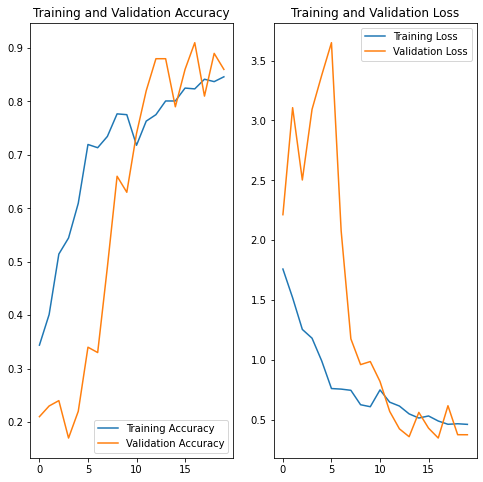

In [27]:
result_plotting(history_model1,len(history_model1.epoch))

__Observations:__

1. __According to accuracy of the model both training and validation achieved around 90% accuracy.__
2. __Despite of high accuracy the consistency is not well maintained in this model.__
3. __Overfitting is visible in accuracy and loss graphs.__

### Model 2 :  similar as Model 1 change in hyper parameters

__Resolution - 120x120 / Frames - 30 / Batch Size - 10 / epoch - 25__

In [28]:
conv_3d2=ModelConv3D1()
conv_3d2.set_data_path(data_dir)
conv_3d2.set_image_properties(image_height=120,image_width=120)
conv_3d2.set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=25)
conv_3d2_model=conv_3d2.define_model()
conv_3d2_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_46 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_29 (Activation)  (None, 15, 60, 60, 32)   

In [30]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d2_model)

Total Params: 699269
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.6611 - categorical_accuracy: 0.3605
Epoch 1: val_loss improved from inf to 3.05826, saving model to gestureRecognitionModel_2022-09-1714_43_31.755373\model-00001-1.6611-0.3605-3.0583-0.2100.h5
67/67 [==============================] - 56s 816ms/step - loss: 1.6611 - categorical_accuracy: 0.3605 - val_loss: 3.0583 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2005 - categorical_accuracy: 0.5158
Epoch 2: val_loss did not improve from 3.05826
67/67 [==============================] - 52s 786ms/step - loss: 1.2005 - categorical_accuracy: 0.5158 - val_loss: 4.4134 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.1641 - categorical_accuracy: 0.5566
Epoch 3: val_loss improved from 3.05826 to 2.23820, saving model to gestureRecognitionModel_2022-09-1714_43_31.755373\m

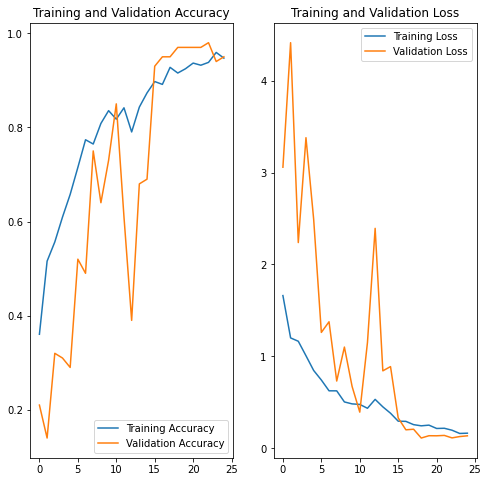

In [31]:
result_plotting(history_model2,len(history_model2.epoch))

__Observations:__

- __Again the model is overfitting and inconsistent with accuracy and loss.__

### Model 3:

__resolution - 100X100 / frames - 30 / batch size - 16 / epoch -25__

In [32]:
conv_3d3=ModelConv3D1()
conv_3d3.set_data_path(data_dir)
conv_3d3.set_image_properties(image_height=100,image_width=100)
conv_3d3.set_hyperparams(frames_to_sample=30,batch_size=16,num_epochs=25)
conv_3d3_model=conv_3d3.define_model()
conv_3d3_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 30, 100, 100, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 30, 100, 100, 16)  0         
                                                                 
 batch_normalization_52 (Bat  (None, 30, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 15, 50, 50, 32)    13856     
                                                                 
 activation_33 (Activation)  (None, 15, 50, 50, 32)  

In [33]:
print("Total Params:", conv_3d3_model.count_params())
history_model3 = conv_3d3.train_model(conv_3d3_model)

Total Params: 592773
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.7139 - categorical_accuracy: 0.3665
Epoch 1: val_loss improved from inf to 1.91139, saving model to gestureRecognitionModel_2022-09-1717_40_59.912094\model-00001-1.7139-0.3665-1.9114-0.2200.h5
42/42 [==============================] - 157s 4s/step - loss: 1.7139 - categorical_accuracy: 0.3665 - val_loss: 1.9114 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.2589 - categorical_accuracy: 0.4917
Epoch 2: val_loss did not improve from 1.91139
42/42 [==============================] - 118s 3s/step - loss: 1.2589 - categorical_accuracy: 0.4917 - val_loss: 2.8563 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.1572 - categorical_accuracy: 0.5520
Epoch 3: val_loss did not improve from 1.91139
42/42 [==============================] - 108s 3s/step - loss: 1.1572 - categ

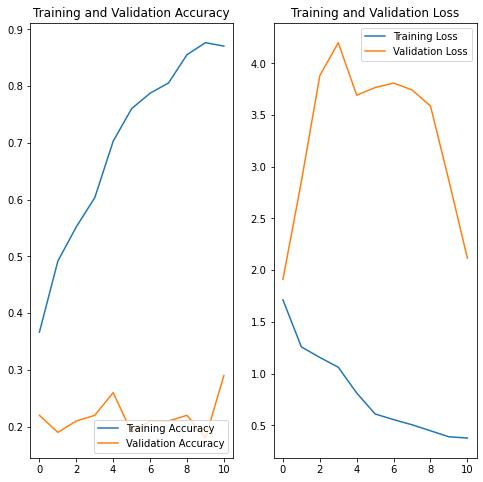

In [34]:
result_plotting(history_model3,len(history_model3.epoch))

__Observations:__

-  __Validation accuracy is very low and validation loss is very high, model does not performed well.__

### Model 4:  Increasing Layers and reducing filters with Augmentation

In [35]:
class ModelConv3D2(ModelBuilder):
    
    def define_model(self,filtersize):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser =  tf.keras.optimizers.Adam(learning_rate=0.002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution - 120X120 / frames - 20 / batch size - 8__

In [36]:
conv_3d4=ModelConv3D2()
conv_3d4.set_data_path(data_dir)
conv_3d4.set_image_properties(image_height=120,image_width=120)
conv_3d4.set_hyperparams(frames_to_sample=20,batch_size=8,num_epochs=20)
conv_3d4_model=conv_3d4.define_model(filtersize=(2,2,2))
conv_3d4_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 20, 120, 120, 16)  400       
                                                                 
 activation_36 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_58 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_37 (Activation)  (None, 10, 60, 60, 32)  

__Setting Augmentation as True__

In [37]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 899893
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.5680 - categorical_accuracy: 0.4148
Epoch 1: val_loss improved from inf to 7.36316, saving model to gestureRecognitionModel_2022-09-1718_20_08.426039\model-00001-1.5680-0.4148-7.3632-0.2100.h5
83/83 [==============================] - 121s 1s/step - loss: 1.5680 - categorical_accuracy: 0.4148 - val_loss: 7.3632 - val_categorical_accuracy: 0.2100 - lr: 0.0020
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.0414 - categorical_accuracy: 0.6109
Epoch 2: val_loss did not improve from 7.36316
83/83 [==============================] - 116s 1s/step - loss: 1.0414 - categorical_accuracy: 0.6109 - val_loss: 11.0564 - val_categorical_accuracy: 0.2000 - lr: 0.0020
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.8661 - categorical_accuracy: 0.6584
Epoch 3: val_loss did not improve from 7.36316
83/83 [==============================] - 117s 1s/step - loss: 0.8661 - cate

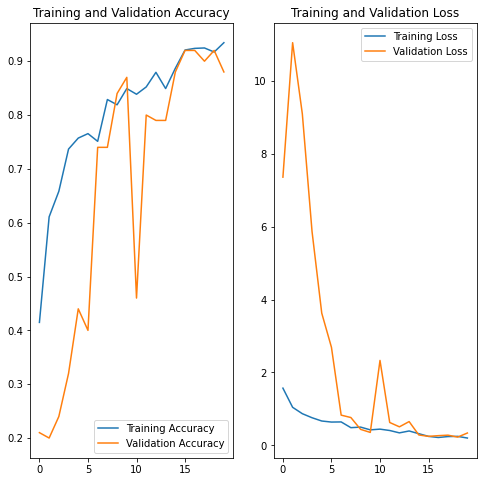

In [38]:
result_plotting(history_model4,len(history_model4.epoch))

__Observations:__

- __Model shows less overfitting than before, but performance inconsistency is still present in the model. Sudden drop in accuracy is observed.__

### Model 5: change in hyper parameters and data augmentation

__Resolution - 100X100 / frames - 25 / batch size - 10__

In [39]:
conv_3d5=ModelConv3D2()
conv_3d5.set_data_path(data_dir)
conv_3d5.set_image_properties(image_height=100,image_width=100)
conv_3d5.set_hyperparams(frames_to_sample=25,batch_size=10,num_epochs=20)
conv_3d5_model=conv_3d5.define_model(filtersize=(2,2,2))
conv_3d5_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 25, 100, 100, 16)  400       
                                                                 
 activation_40 (Activation)  (None, 25, 100, 100, 16)  0         
                                                                 
 batch_normalization_64 (Bat  (None, 25, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 12, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 12, 50, 50, 32)    4128      
                                                                 
 activation_41 (Activation)  (None, 12, 50, 50, 32)  

In [40]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 686901
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5285 - categorical_accuracy: 0.4186
Epoch 1: val_loss improved from inf to 5.24604, saving model to gestureRecognitionModel_2022-09-1718_56_44.527213\model-00001-1.5285-0.4186-5.2460-0.1600.h5
67/67 [==============================] - 73s 1s/step - loss: 1.5285 - categorical_accuracy: 0.4186 - val_loss: 5.2460 - val_categorical_accuracy: 0.1600 - lr: 0.0020
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1264 - categorical_accuracy: 0.5588
Epoch 2: val_loss did not improve from 5.24604
67/67 [==============================] - 70s 1s/step - loss: 1.1264 - categorical_accuracy: 0.5588 - val_loss: 5.5235 - val_categorical_accuracy: 0.1600 - lr: 0.0020
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9995 - categorical_accuracy: 0.6259
Epoch 3: val_loss improved from 5.24604 to 4.52676, saving model to gestureRecognitionModel_2022-09-1718_56_44.527213\model-0

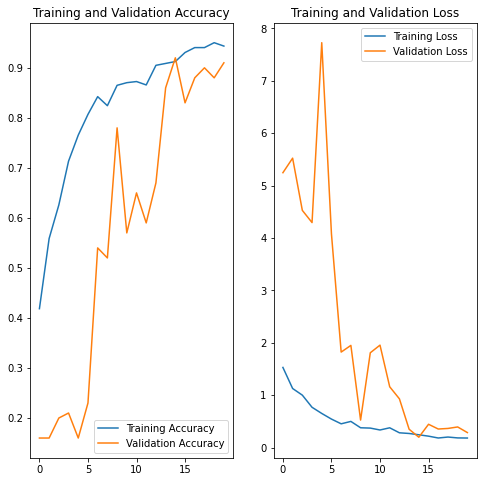

In [41]:
result_plotting(history_model5,len(history_model5.epoch))

__Observations:__

- __Overfitting is not there but performance of the model is not consistent here as well.__

### Model 6:  Adding dropout layers in the model

In [42]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution - 120X120 / frames - 20 / batch size -8 / epoch -20__

In [45]:
conv_3d6=ModelConv3D3()
conv_3d6.set_data_path(data_dir)
conv_3d6.set_image_properties(image_height=120,image_width=120)
conv_3d6.set_hyperparams(frames_to_sample=20,batch_size=8,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_80 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_53 (Conv3D)          (None, 20, 120, 120, 16)  6928      
                                                                 
 activation_53 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_81 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                    

In [46]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 1702645
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.7666 - categorical_accuracy: 0.3341
Epoch 1: val_loss improved from inf to 3.13730, saving model to gestureRecognitionModel_2022-09-1719_27_57.941267\model-00001-1.7666-0.3341-3.1373-0.2000.h5
83/83 [==============================] - 77s 858ms/step - loss: 1.7666 - categorical_accuracy: 0.3341 - val_loss: 3.1373 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.4188 - categorical_accuracy: 0.4442
Epoch 2: val_loss improved from 3.13730 to 3.04319, saving model to gestureRecognitionModel_2022-09-1719_27_57.941267\model-00002-1.4188-0.4442-3.0432-0.1700.h5
83/83 [==============================] - 67s 804ms/step - loss: 1.4188 - categorical_accuracy: 0.4442 - val_loss: 3.0432 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.1867 - categorical_accuracy: 0.5317
Epoc

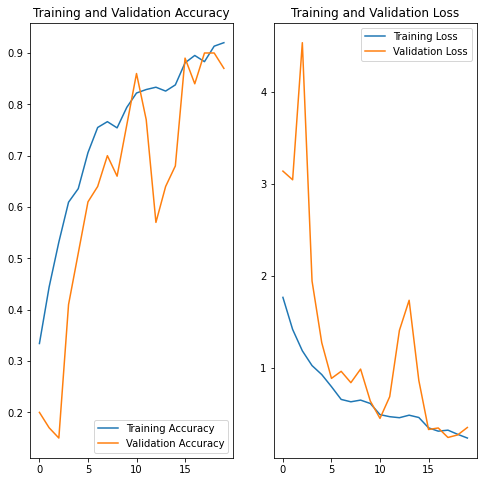

In [47]:
result_plotting(history_model6,len(history_model6.epoch))

__Observations:__

- __Model 6 also does not show any drastic performance improvement.__

### Model 7:  Reducing number of parameters

In [48]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution - 100X100 / frames - 20 / batch size - 10__

In [49]:
conv_3d7=ModelConv3D4()
conv_3d7.set_data_path(data_dir)
conv_3d7.set_image_properties(image_height=100,image_width=100)
conv_3d7.set_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=20)
conv_3d7_model=conv_3d7.define_model(dense_neurons=128,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 20, 100, 100, 16)  400       
                                                                 
 activation_60 (Activation)  (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 50, 50, 32)    4128      
                                                                 
 activation_61 (Activation)  (None, 10, 50, 50, 32)  

In [50]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 695733
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4325 - categorical_accuracy: 0.4894
Epoch 1: val_loss improved from inf to 4.28239, saving model to gestureRecognitionModel_2022-09-1719_55_56.323164\model-00001-1.4325-0.4894-4.2824-0.2100.h5
67/67 [==============================] - 55s 798ms/step - loss: 1.4325 - categorical_accuracy: 0.4894 - val_loss: 4.2824 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0273 - categorical_accuracy: 0.6342
Epoch 2: val_loss did not improve from 4.28239
67/67 [==============================] - 54s 810ms/step - loss: 1.0273 - categorical_accuracy: 0.6342 - val_loss: 5.9218 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6576 - categorical_accuracy: 0.7572
Epoch 3: val_loss did not improve from 4.28239
67/67 [==============================] - 53s 799ms/step - loss: 0.6576 -

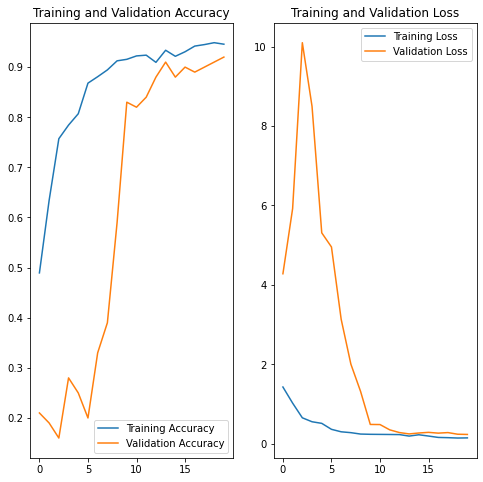

In [51]:
result_plotting(history_model7,len(history_model7.epoch))

__Observations:__

- __Model performance is consistent than previous models and overfitting also not observed.__
- __Model achieved Training Accuracy of 94% and  Validation Accuracy of 92%.__
- __Also both training and validation loss in minimal around 0.15 and 0.23 respectively.__

__Above Model 7 gives us good performance still let us experiment with the Model to find more better performance.__

### Model 8: Reducing more parameters

In [52]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution - 120X120 /frames - 20 / batch size - 10__

In [53]:
conv_3d8=ModelConv3D5()
conv_3d8.set_data_path(data_dir)
conv_3d8.set_image_properties(image_height=120,image_width=120)
conv_3d8.set_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=20)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_64 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_96 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_65 (Activation)  (None, 10, 60, 60, 32)  

In [54]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 504709
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4931 - categorical_accuracy: 0.4178
Epoch 1: val_loss improved from inf to 4.97547, saving model to gestureRecognitionModel_2022-09-1720_32_24.221583\model-00001-1.4931-0.4178-4.9755-0.2100.h5
67/67 [==============================] - 60s 856ms/step - loss: 1.4931 - categorical_accuracy: 0.4178 - val_loss: 4.9755 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0525 - categorical_accuracy: 0.5716
Epoch 2: val_loss did not improve from 4.97547
67/67 [==============================] - 56s 845ms/step - loss: 1.0525 - categorical_accuracy: 0.5716 - val_loss: 9.5053 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9198 - categorical_accuracy: 0.6606
Epoch 3: val_loss did not improve from 4.97547
67/67 [==============================] - 56s 844ms/step - loss: 0.9198 -

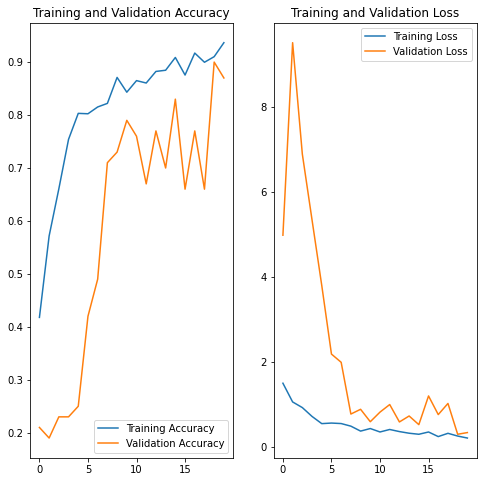

In [55]:
result_plotting(history_model8,len(history_model8.epoch))

__Observations:__

- __Model is not overfitting but model shows inconsistency in higher epochs.__
- __Validation loss is also nit higher than the previous model.__

### Model 9 : changing the hyper parameters

__Resolution - 120X120 /frames - 18 / batch size - 10 / epochs - 25__

In [56]:
conv_3d9=ModelConv3D5()
conv_3d9.set_data_path(data_dir)
conv_3d9.set_image_properties(image_height=120,image_width=120)
conv_3d9.set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=25)
conv_3d9_model=conv_3d9.define_model(dense_neurons=64,dropout=0.25)
conv_3d9_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_102 (Ba  (None, 18, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 9, 60, 60, 32)     13856     
                                                                 
 activation_69 (Activation)  (None, 9, 60, 60, 32)   

In [57]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 504709
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5017 - categorical_accuracy: 0.4276
Epoch 1: val_loss improved from inf to 2.10690, saving model to gestureRecognitionModel_2022-09-1721_07_57.606671\model-00001-1.5017-0.4276-2.1069-0.2400.h5
67/67 [==============================] - 59s 857ms/step - loss: 1.5017 - categorical_accuracy: 0.4276 - val_loss: 2.1069 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.1020 - categorical_accuracy: 0.5520
Epoch 2: val_loss did not improve from 2.10690
67/67 [==============================] - 53s 794ms/step - loss: 1.1020 - categorical_accuracy: 0.5520 - val_loss: 4.0527 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.8541 - categorical_accuracy: 0.6644
Epoch 3: val_loss did not improve from 2.10690
67/67 [==============================] - 50s 755ms/step - loss: 0.8541 -

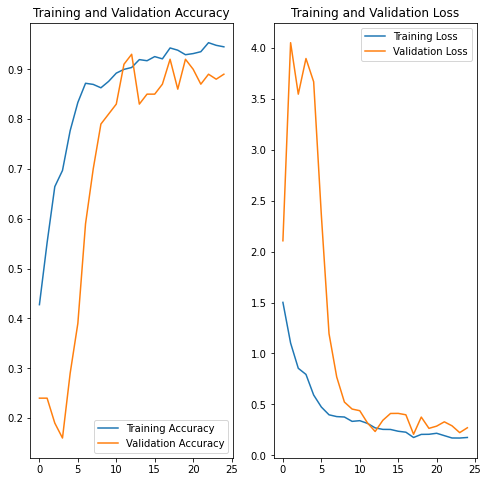

In [58]:
result_plotting(history_model9,len(history_model9.epoch))

__Observations:__

1. __Despite of some overfitting near 10-14 th epoch the model performed well.__
2. __We achieved maximum training accuracy of 94% and validation accuracy of 92%.__
3. __Also minimum training loss is 0.17 and validation loss is 0.21.__

### Now Let us build some model with slightly changed Augmentation techniques and observe the model results.

__We are adding random rotation and normalization techniques as augmentation to existing generator module.__

### New Data Generator and Augmentation Class :

In [10]:
class ModelBuilderModifiedAugmentation(metaclass= abc.ABCMeta):
    
    # Loads the training and validation data from the data directory.
    def new_set_path(self,project_folder):
        self.train_data_list = np.random.permutation(open(data_dir + '\\' + 'train.csv').readlines())
        self.val_data_list = np.random.permutation(open(data_dir + '\\' + 'val.csv').readlines())
        self.train_data_path = data_dir + '\\' + 'train'
        self.val_data_path =  data_dir + '\\' + 'val'
        self.num_train_sequences = len(self.train_data_list)
        self.num_val_sequences = len(self.val_data_list)
    
    # initialising the image dimension, frame size and color channels  
    def new_set_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # initialising the basic hyper parameters for model batchsize, epochs & frames to process    
    def new_set_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # applying pre processing, augmentation of the data
    def new_get_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
        
        # augmentation will only be apllied when it will be set as true in model param
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'\\'+ t[folder + (batch*batch_size)].split(';')[0])
            
            for idx,item in enumerate(img_idx):
                #image reading and resizing
                image = imread(source_path+'\\'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                # augmentation will only be apllied when it will be set as true in model param
                if (augment):
                    shiftedImages = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shiftedImages,cv2.COLOR_BGR2GRAY) # converting to grayscale

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    # cropping the images to have focus on the main gesture part in the image
                    cropped=shiftedImages[x0:x1,y0:y1,:]
                    
                    #resizing the cropped image
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    # new method added to random rotate the images
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    # normalizing the augmented images
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        # augmentation will only be apllied when it will be set as true in model param
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        # returning procesed data 
        return(batch_data,batch_labels)
    
    # Function generates the data for processing based on batch size and random combination mentioned  
    def new_data_generator(self,source_path, folder_list, augment=False):
        
        #index of the image
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            
            #returning the data in combined batches
            for batch in range(num_batches): 
                batch_data, batch_labels= self.new_get_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.new_get_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    # function defined to train, load and save the model details 
    def train_model(self, model, augment_data=False):
        train_generator = self.new_data_generator(self.train_data_path, self.train_data_list,augment=augment_data) # train data 
        val_generator = self.new_data_generator(self.val_data_path, self.val_data_list) # validation data
        

        model_name = 'gestureRecognitionModel' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        
        # details to be saved on model training
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        # no early stopping
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        # saving the history of the model
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    

#### Testing the new Data Generator with Random selection of Images :

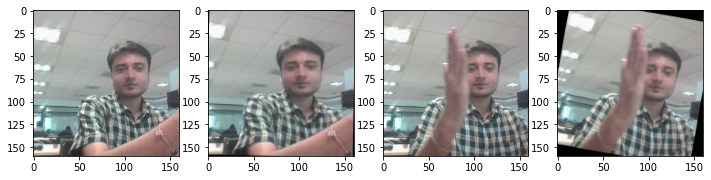

In [11]:
class Test(ModelBuilderModifiedAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.new_set_path(data_dir)
test_generator.new_set_image_properties(image_height=160,image_width=160)
test_generator.new_set_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.new_data_generator(test_generator.val_data_path,test_generator.val_data_list,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(12, 12))
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:]) 
axes[2].imshow(batch_data[0,15,:,:,:]) 
axes[3].imshow(batch_data[3,15,:,:,:]) 
plt.show()

### Building New set of Models using new Augmentation and Data Generator :

### MODEL 10:  New Data Generator and Augmentation

In [61]:
class ModelConv3D6(ModelBuilderModifiedAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution - 160X160 / frames - 20 / batch size - 4__ 

In [64]:
conv_3d10=ModelConv3D6()
conv_3d10.new_set_path(data_dir)
conv_3d10.new_set_image_properties(image_height=160,image_width=160)
conv_3d10.new_set_hyperparams(frames_to_sample=20,batch_size=4,num_epochs=20)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_76 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_114 (Ba  (None, 20, 160, 160, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_77 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_77 (Activation)  (None, 10, 80, 80, 32)  

In [65]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 2.3193 - categorical_accuracy: 0.2934
Epoch 1: saving model to gestureRecognitionModel_2022-09-1722_23_25.255454\model-00001-2.31934-0.29336-3.51351-0.22000.h5
166/166 [==============================] - 70s 408ms/step - loss: 2.3193 - categorical_accuracy: 0.2934 - val_loss: 3.5135 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 2.0638 - categorical_accuracy: 0.2798
Epoch 2: saving model to gestureRecognitionModel_2022-09-1722_23_25.255454\model-00002-2.06377-0.27979-3.45408-0.29000.h5
166/166 [==============================] - 71s 428ms/step - loss: 2.0638 - categorical_accuracy: 0.2798 - val_loss: 3.4541 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 1.8184 - categorical_accuracy: 0.3160
Epoch 3: saving model to gestureRecognitionModel_2022-09-1722_23_25.

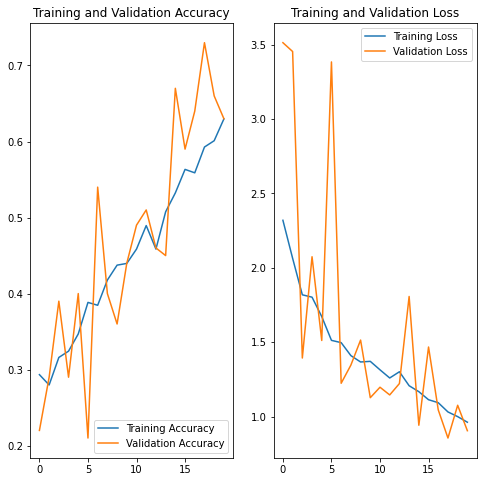

In [66]:
result_plotting(history_model10,len(history_model10.epoch))

__Observations:__

- __Model clearly showing poor performance and over fitting.__

### Model 11: Reducing filter size and hyper parameters

In [13]:
class ModelConv3D7(ModelBuilderModifiedAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution 120X120 / frames - 25 / batch size - 8__

In [14]:
conv_3d11=ModelConv3D7()
conv_3d11.new_set_path(data_dir)
conv_3d11.new_set_image_properties(image_height=120,image_width=120)
conv_3d11.new_set_hyperparams(frames_to_sample=25,batch_size=8,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 25, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 25, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 25, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 60, 60, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 12, 60, 60, 32)    0

In [15]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8628 - categorical_accuracy: 0.4020
Epoch 1: saving model to gestureRecognitionModel_2022-09-1810_27_11.392356\model-00001-1.86280-0.40196-4.96400-0.16000.h5
83/83 [==============================] - 196s 2s/step - loss: 1.8628 - categorical_accuracy: 0.4020 - val_loss: 4.9640 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.2991 - categorical_accuracy: 0.5483
Epoch 2: saving model to gestureRecognitionModel_2022-09-1810_27_11.392356\model-00002-1.29906-0.54827-5.35744-0.24000.h5
83/83 [==============================] - 156s 2s/step - loss: 1.2991 - categorical_accuracy: 0.5483 - val_loss: 5.3574 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.0499 - categorical_accuracy: 0.6335
Epoch 3: saving model to gestureRecognitionModel_2022-09-1810_27_11.392356\model-0

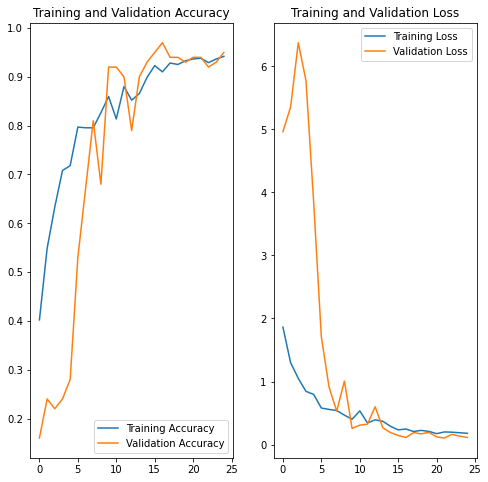

In [16]:
result_plotting(history_model11,len(history_model11.epoch))

__Observations:__

- __Model performs well but there inconsistency observed in high epoch value.__

### Model 12: Same model with different hyper parameters

__Resolution 120X120 / frames - 18 / batch size - 10__

In [18]:
conv_3d12=ModelConv3D7()
conv_3d12.new_set_path(data_dir)
conv_3d12.new_set_image_properties(image_height=120,image_width=120)
conv_3d12.new_set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=20)
conv_3d12_model=conv_3d12.define_model(filtersize=(2,2,2),dense_neurons=128,dropout=0.5)
conv_3d12_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 18, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 9, 60, 60, 32)    

In [19]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 908725
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.8380 - categorical_accuracy: 0.3763
Epoch 1: saving model to gestureRecognitionModel_2022-09-1811_04_24.468421\model-00001-1.83797-0.37632-2.38467-0.17000.h5
67/67 [==============================] - 60s 880ms/step - loss: 1.8380 - categorical_accuracy: 0.3763 - val_loss: 2.3847 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3338 - categorical_accuracy: 0.5128
Epoch 2: saving model to gestureRecognitionModel_2022-09-1811_04_24.468421\model-00002-1.33380-0.51282-3.23469-0.12000.h5
67/67 [==============================] - 52s 780ms/step - loss: 1.3338 - categorical_accuracy: 0.5128 - val_loss: 3.2347 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0618 - categorical_accuracy: 0.6063
Epoch 3: saving model to gestureRecognitionModel_2022-09-1811_04_24.468421\mode

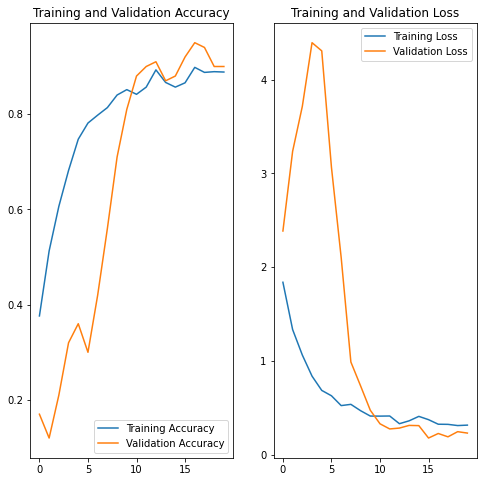

In [20]:
result_plotting(history_model12,len(history_model12.epoch))

__Observations:__

- __After 10th epoch Model is overfitting.__


### Model 13: Adding more layers and dropout

In [21]:
class ModelConv3D8(ModelBuilderModifiedAugmentation):
    
    def define_model(self,filtersize,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(0.005)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


__Resolution 120X120 / frames - 18 / batch size -10__

In [22]:
conv_3d13=ModelConv3D8()
conv_3d13.new_set_path(data_dir)
conv_3d13.new_set_image_properties(image_height=120,image_width=120)
conv_3d13.new_set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=20)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 18, 120, 120, 16)  6928      
                                                                 
 activation_9 (Activation)   (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_13 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                     

In [23]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.9146 - categorical_accuracy: 0.3130
Epoch 1: saving model to gestureRecognitionModel_2022-09-1811_48_39.081420\model-00001-1.91465-0.31297-302.46042-0.16000.h5
67/67 [==============================] - 70s 949ms/step - loss: 1.9146 - categorical_accuracy: 0.3130 - val_loss: 302.4604 - val_categorical_accuracy: 0.1600 - lr: 0.0050
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.6041 - categorical_accuracy: 0.3786
Epoch 2: saving model to gestureRecognitionModel_2022-09-1811_48_39.081420\model-00002-1.60413-0.37858-4.21123-0.18000.h5
67/67 [==============================] - 59s 887ms/step - loss: 1.6041 - categorical_accuracy: 0.3786 - val_loss: 4.2112 - val_categorical_accuracy: 0.1800 - lr: 0.0050
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.6869 - categorical_accuracy: 0.3620
Epoch 3: saving model to gestureRecognitionModel_2022-09-1811_48_39.081420

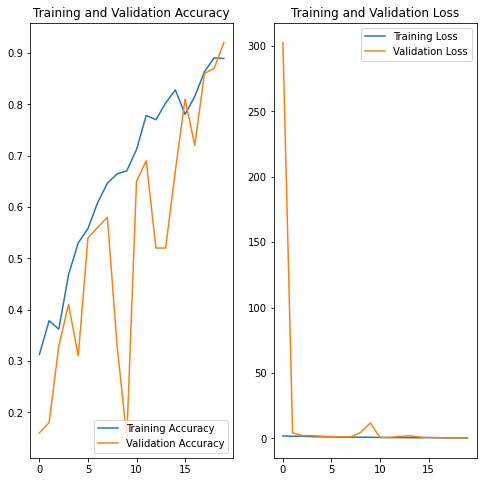

In [25]:
result_plotting(history_model13,len(history_model13.epoch))

__Observations:__

- __Model is still showing overfitting behaviour and there is no consistency observed in performance.__

### Model 14: Reducing network parameters

In [26]:
class ModelConv3D9(ModelBuilderModifiedAugmentation):
    
    def define_model(self,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution 120X120 / frames - 18 / batch size - 10__

In [27]:
conv_3d14=ModelConv3D9()
conv_3d14.new_set_path(data_dir)
conv_3d14.new_set_image_properties(image_height=120,image_width=120)
conv_3d14.new_set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=20)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_22 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 9, 60, 60, 32)     13856     
                                                                 
 activation_17 (Activation)  (None, 9, 60, 60, 32)    

In [28]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 919365
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5286 - categorical_accuracy: 0.4419
Epoch 1: saving model to gestureRecognitionModel_2022-09-1812_12_27.599110\model-00001-1.52865-0.44193-6.95223-0.16000.h5
67/67 [==============================] - 53s 777ms/step - loss: 1.5286 - categorical_accuracy: 0.4419 - val_loss: 6.9522 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0276 - categorical_accuracy: 0.6259
Epoch 2: saving model to gestureRecognitionModel_2022-09-1812_12_27.599110\model-00002-1.02759-0.62594-5.62565-0.15000.h5
67/67 [==============================] - 51s 764ms/step - loss: 1.0276 - categorical_accuracy: 0.6259 - val_loss: 5.6256 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8299 - categorical_accuracy: 0.6870
Epoch 3: saving model to gestureRecognitionModel_2022-09-1812_12_27.599110\mode

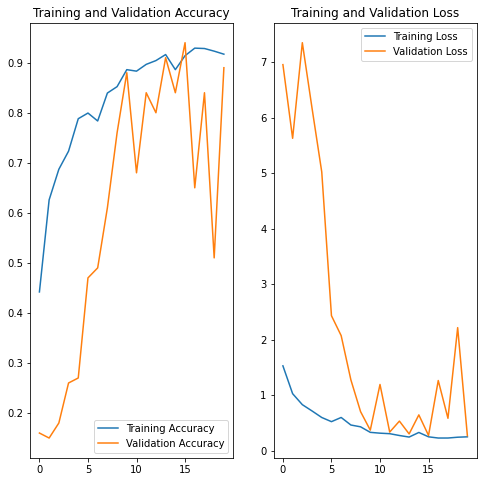

In [29]:
result_plotting(history_model14,len(history_model14.epoch))

__Observations:__

- __Overfitting issue is resolved in this model but model performance is not very stable in this model.__

### Let us implements some Model with LSTM cells and check the Model behaviour:

### Model 15: CNN (Conv2d) + LSTM Model ( without rotation augmentation )

In [32]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells,dense_neurons,dropout):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))  ## adding LSTM layers
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution 120X120 / frames - 18 / batch size - 10__

In [33]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.set_data_path(data_dir)
rnn_cnn1.set_image_properties(image_height=120,image_width=120)
rnn_cnn1.set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [34]:
print("Total Params:", rnn_cnn1_model.count_params())
history_rnncnn1=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3829 - categorical_accuracy: 0.3929
Epoch 1: val_loss improved from inf to 2.08288, saving model to gestureRecognitionModel_2022-09-1812_35_47.622781\model-00001-1.3829-0.3929-2.0829-0.2100.h5
67/67 [==============================] - 60s 821ms/step - loss: 1.3829 - categorical_accuracy: 0.3929 - val_loss: 2.0829 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0714 - categorical_accuracy: 0.5875
Epoch 2: val_loss did not improve from 2.08288
67/67 [==============================] - 53s 792ms/step - loss: 1.0714 - categorical_accuracy: 0.5875 - val_loss: 3.0725 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8814 - categorical_accuracy: 0.6606
Epoch 3: val_loss did not improve from 2.08288
67/67 [==============================] - 51s 767ms/step - loss: 0.8814 

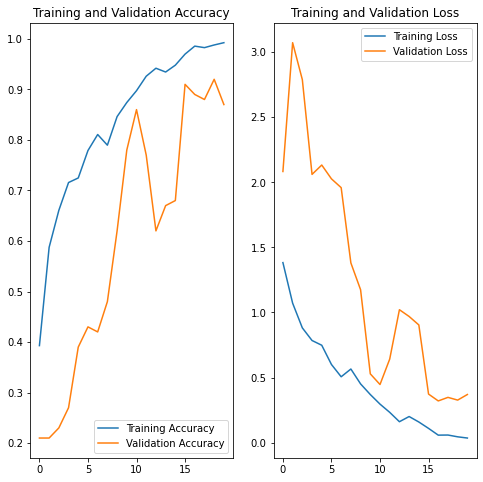

In [35]:
result_plotting(history_rnncnn1,len(history_rnncnn1.epoch))

__Observations:__

- __Model is not overfitting.__
- __Model shows high training accuracy and low training loss but on the other hand validation accuracy is bit low, also validation loss is high.__

### Model 16: Changing the model hyper parameters

__Resolution - 120X120 / frames - 20 / batch size -8__

In [36]:
rnn_cnn2=RNNCNN1()
rnn_cnn2.set_data_path(data_dir)
rnn_cnn2.set_image_properties(image_height=120,image_width=120)
rnn_cnn2.set_hyperparams(frames_to_sample=20,batch_size=8,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 60, 60, 32)  

In [37]:
print("Total Params:", rnn_cnn2_model.count_params())
history_rnncnn2=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.3704 - categorical_accuracy: 0.4223
Epoch 1: val_loss improved from inf to 2.13046, saving model to gestureRecognitionModel_2022-09-1813_43_47.008570\model-00001-1.3704-0.4223-2.1305-0.2100.h5
83/83 [==============================] - 72s 815ms/step - loss: 1.3704 - categorical_accuracy: 0.4223 - val_loss: 2.1305 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.0742 - categorical_accuracy: 0.5890
Epoch 2: val_loss did not improve from 2.13046
83/83 [==============================] - 55s 673ms/step - loss: 1.0742 - categorical_accuracy: 0.5890 - val_loss: 2.3918 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.9351 - categorical_accuracy: 0.6373
Epoch 3: val_loss did not improve from 2.13046
83/83 [==============================] - 56s 680ms/step - loss: 0.9351 

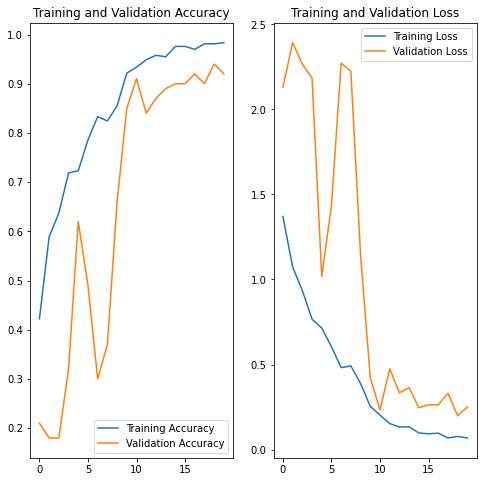

In [38]:
result_plotting(history_rnncnn2,len(history_rnncnn2.epoch))

__Observations:__

- __Model overall performs good.__
- __Model shows good training loss as minimum as 0.08 and validation loss as minimum as 0.2.__
- __Both the accuracy is also over 90%.__


### Model 17: CNN (Conv2D) LSTM with GRU 

In [39]:
class RNNCNN2(ModelBuilderModifiedAugmentation):
    
    def define_model(self,lstm_cells,dense_neurons,dropout):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution 120X120 / frames - 18 / batch size -10__

In [40]:
rnn_cnn3=RNNCNN2()
rnn_cnn3.new_set_path(data_dir)
rnn_cnn3.new_set_image_properties(image_height=120,image_width=120)
rnn_cnn3.new_set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=20)
rnn_cnn3_model=rnn_cnn3.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn3_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 60, 60, 32)  

In [41]:
print("Total Params:", rnn_cnn3_model.count_params())
history_rnncnn3=rnn_cnn3.train_model(rnn_cnn3_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3888 - categorical_accuracy: 0.4186
Epoch 1: saving model to gestureRecognitionModel_2022-09-1814_18_23.340656\model-00001-1.38883-0.41855-1.63978-0.17000.h5
67/67 [==============================] - 58s 835ms/step - loss: 1.3888 - categorical_accuracy: 0.4186 - val_loss: 1.6398 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1178 - categorical_accuracy: 0.5543
Epoch 2: saving model to gestureRecognitionModel_2022-09-1814_18_23.340656\model-00002-1.11782-0.55430-1.84039-0.25000.h5
67/67 [==============================] - 52s 783ms/step - loss: 1.1178 - categorical_accuracy: 0.5543 - val_loss: 1.8404 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8853 - categorical_accuracy: 0.6614
Epoch 3: saving model to gestureRecognitionModel_2022-09-1814_18_23.340656\mod

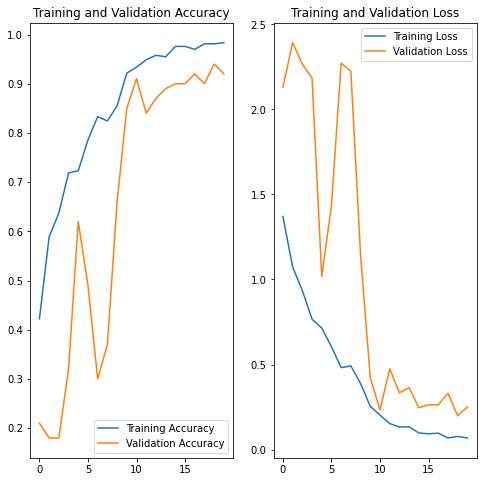

In [42]:
result_plotting(history_rnncnn2,len(history_rnncnn2.epoch))

__Observations:__

- __Model accuracy and loss scores are good but model performance is not consistence.__

### Applying already Developed Models as a Initial Layer as Transfer Learning :

### Model 18 : Imagenet as Transfer learning with LSTM

In [43]:
# importing mobilenet architecture library

from keras.applications import mobilenet

In [44]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False) # importing imagenet trained weights

class RNNCNN_TL(ModelBuilderModifiedAugmentation):
    
    def define_model(self,lstm_cells,dense_neurons,dropout):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
rnncnn_tl1=RNNCNN_TL()
rnncnn_tl1.new_set_path(data_dir)
rnncnn_tl1.new_set_image_properties(image_height=120,image_width=120)
rnncnn_tl1.new_set_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=20)
rnncnn_tl1_model=rnncnn_tl1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnncnn_tl1_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [46]:
print("Total Params:", rnncnn_tl1_model.count_params())
history_rnncnn_tl1=rnncnn_tl1.train_model(rnncnn_tl1_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2478 - categorical_accuracy: 0.4834
Epoch 1: saving model to gestureRecognitionModel_2022-09-1814_49_28.410717\model-00001-1.24783-0.48341-0.72750-0.75000.h5
67/67 [==============================] - 63s 869ms/step - loss: 1.2478 - categorical_accuracy: 0.4834 - val_loss: 0.7275 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6254 - categorical_accuracy: 0.7798
Epoch 2: saving model to gestureRecognitionModel_2022-09-1814_49_28.410717\model-00002-0.62542-0.77979-0.60803-0.74000.h5
67/67 [==============================] - 50s 756ms/step - loss: 0.6254 - categorical_accuracy: 0.7798 - val_loss: 0.6080 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4443 - categorical_accuracy: 0.8514
Epoch 3: saving model to gestureRecognitionModel_2022-09-1814_49_28.410717\mod

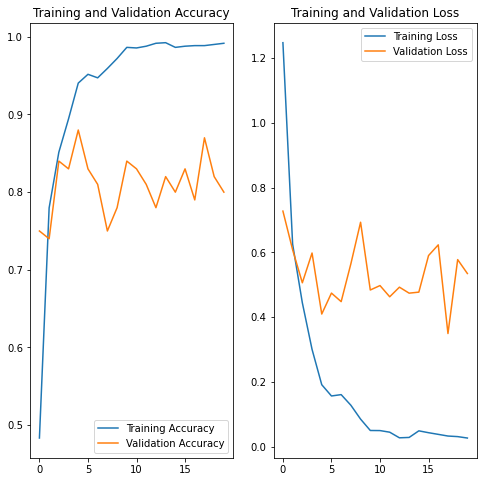

In [47]:
result_plotting(history_rnncnn_tl1,len(history_rnncnn_tl1.epoch))

__Observations:__

- __Validation accuracy and validation loss doesn't improve with epochs.__

### Model 19: Transfer Learning with GRU and training all weights

In [48]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL_GRU2(ModelBuilderModifiedAugmentation):
    
    def define_model(self,gru_cells,dense_neurons,dropout):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

__Resolution 120X120 / frames - 18 / batch size - 4__

In [49]:
rnncnn_tl_gru2=RNNCNN_TL_GRU2()
rnncnn_tl_gru2.new_set_path(data_dir)
rnncnn_tl_gru2.new_set_image_properties(image_height=120,image_width=120)
rnncnn_tl_gru2.new_set_hyperparams(frames_to_sample=18,batch_size=4,num_epochs=20)
rnncnn_tl_gru2_model=rnncnn_tl_gru2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnncnn_tl_gru2_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_49 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [50]:
print("Total Params:", rnncnn_tl_gru2_model.count_params())
history_rnncnn_tl_gru2=rnncnn_tl_gru2.train_model(rnncnn_tl_gru2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 0.9115 - categorical_accuracy: 0.6652
Epoch 1: saving model to gestureRecognitionModel_2022-09-1815_18_36.639200\model-00001-0.91151-0.66516-0.56905-0.81000.h5
166/166 [==============================] - 73s 398ms/step - loss: 0.9115 - categorical_accuracy: 0.6652 - val_loss: 0.5691 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 0.4481 - categorical_accuracy: 0.8582
Epoch 2: saving model to gestureRecognitionModel_2022-09-1815_18_36.639200\model-00002-0.44813-0.85822-0.31676-0.90000.h5
166/166 [==============================] - 64s 384ms/step - loss: 0.4481 - categorical_accuracy: 0.8582 - val_loss: 0.3168 - val_categorical_accuracy: 0.9000 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.3034 - categorical_accuracy: 0.9050
Epoch 3: saving model to gestureRecognitionModel_2022-09-1815_18_36.

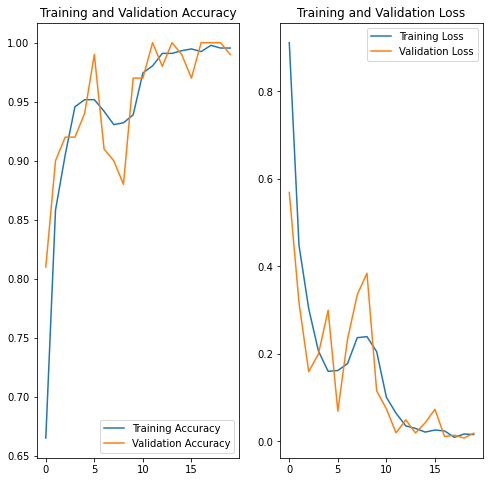

In [51]:
result_plotting(history_rnncnn_tl_gru2,len(history_rnncnn_tl_gru2.epoch))

__Observations:__

- __Model is overfitting.__
- __Model performance is not consistence.__

## Comparing all Models performance:

__Below we have listed down all the 19 model and its performance details:__

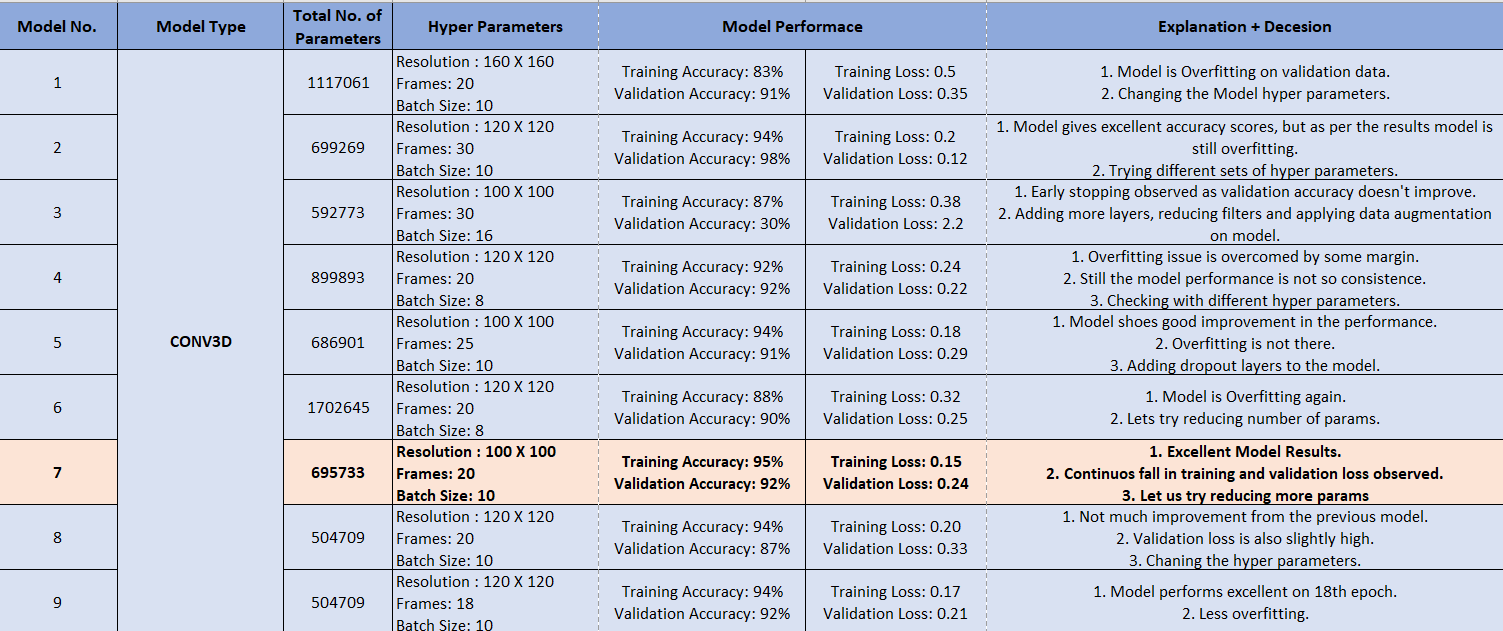 

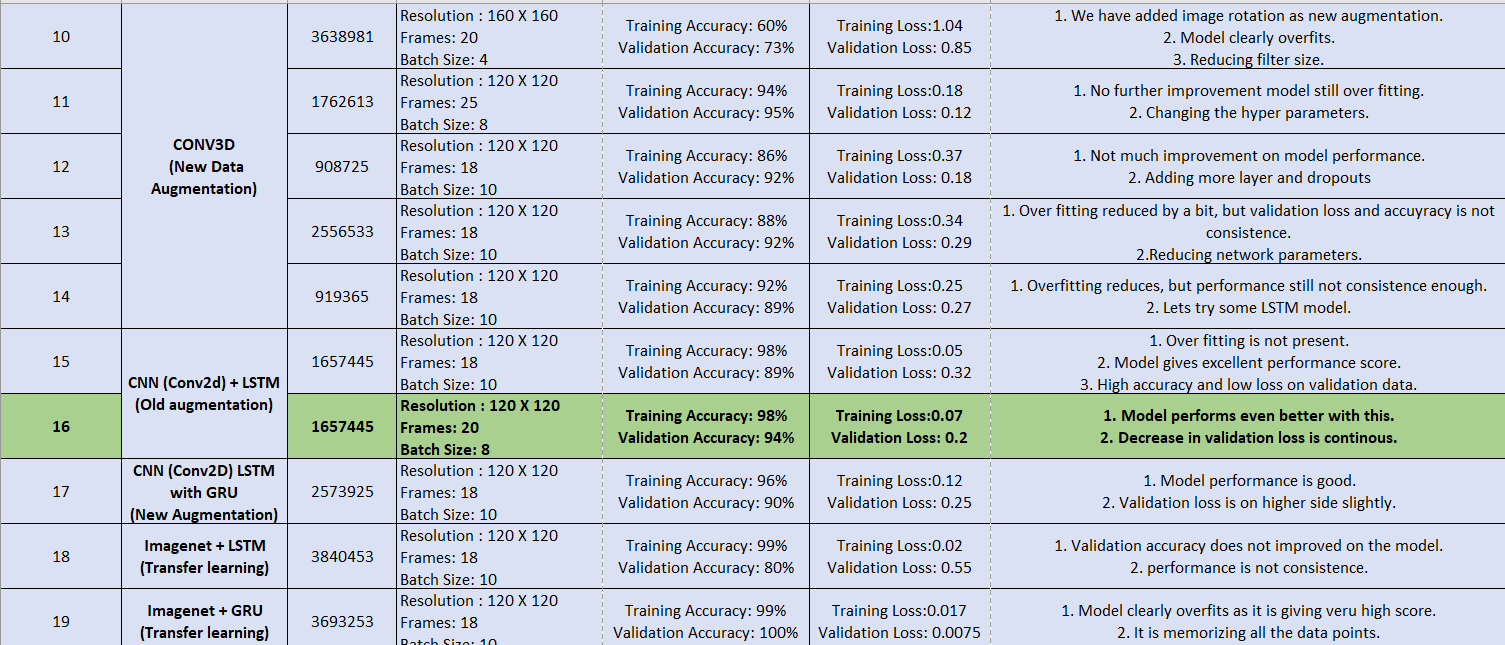

### __Observation:__

1. __Out of all the 19 models, Model 7 and Model 16 gives us very good results.__
2. __Both model gives accuracy over 90% on training and validation data.__
3. __Validation loss on both the models are gradually decreasing after 10-12th epochs.__

### Selecting the Final Model :

## Model 16 - CNN (Conv2D) + LSTM Model is selected as out final model.

__Reasons:__

1. __Model 16 gives training accuracy of 98% and validation accuracy of 94%, from accuracy point of view we also have similar kind of good performance in Model 7 as well.__
2. __Model 16 gives very low training loss of 0.07 and validation loss of 0.2, which is better than Model 7.__ 
3. __Though we observed some fluctuation in early epochs, but after 10th epochs learning rate decreases and validation loss goes to minimum on a continuous drop.__

### Best trained weights of Model 16 is selected from 19th epoch is : model-00019-0.0776-0.9811-0.1996-0.9400.h5

__We will be using the following model trained weights to predict the data in future purpose.__

## FINAL MODEL SUMMARY:

In [9]:
from tensorflow.keras.utils import plot_model

In [10]:
class CNN_LSTM_FINAL(ModelBuilder):
    
    def define_model(self,lstm_cells,dense_neurons,dropout):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))  ## adding LSTM layers
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
cnn_lstm_final = CNN_LSTM_FINAL()
cnn_lstm_final.set_data_path(data_dir)
cnn_lstm_final.set_image_properties(image_height=120,image_width=120)
cnn_lstm_final.set_hyperparams(frames_to_sample=20,batch_size=8,num_epochs=20)
cnn_lstm_final_model=cnn_lstm_final.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)

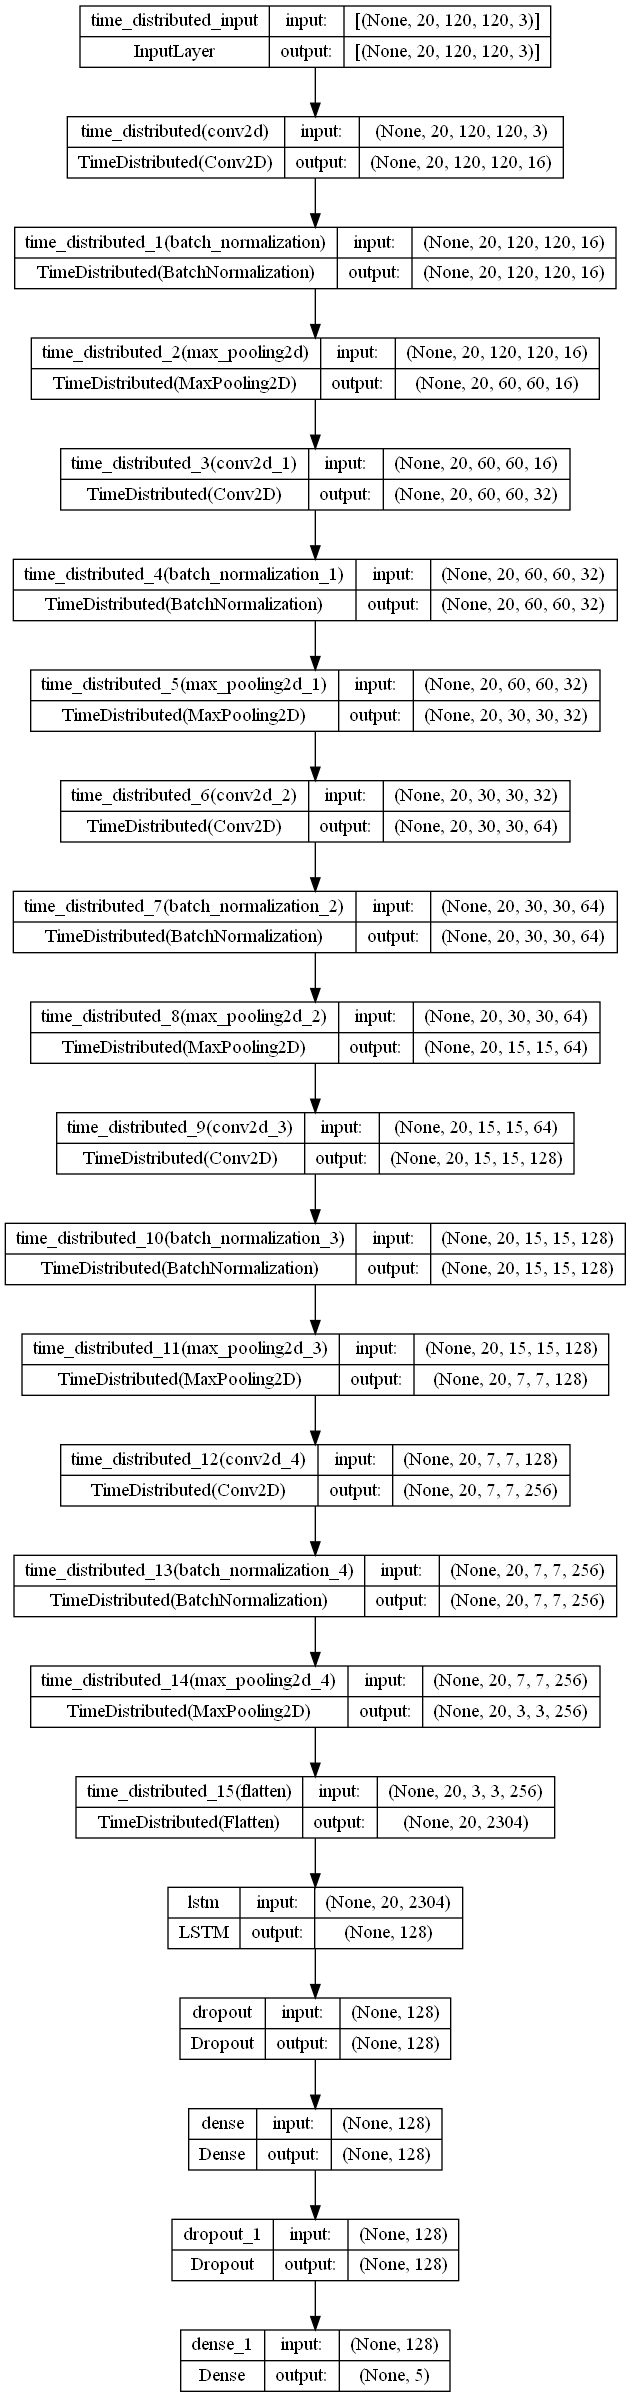

In [12]:
# plotting the model
plot_model(cnn_lstm_final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

=========================================================================================================